In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dataset import NASBench101Dataset
from utils import get_targets, get_flat_features, get_flat_features_boosted

In [3]:
%load_ext snakeviz

### Dataset load
- [] Different splits? (use `train_test_split`?)
- [] Test data should be unseen data

In [4]:
dataset = NASBench101Dataset('data/nasbench101.hdf5', "2000") 
dataset_test = NASBench101Dataset('data/nasbench101.hdf5', "all")
dataset_size = len(dataset)

### Get Features
- [] Correlation analysis (can be done on current?)
- [] Additional Features 
- [] Better way of getting features (dataset.py or utils.py)
- [] Normalization check

In [5]:
# Reduce dataset_test to random 20000 samples
random_state = np.random.RandomState(0)
indices = random_state.permutation(len(dataset_test))[:20000]
dataset_test = [a for i, a in enumerate(dataset_test) if i in indices]

In [6]:
# Get train and test data
train_data = get_flat_features(dataset)
test_data = get_flat_features(dataset_test)

# Get train and test targets
train_targets = get_targets(dataset)
test_targets = get_targets(dataset_test)

In [6]:
train_data_boosted = get_flat_features_boosted(dataset)
test_data_boosted = get_flat_features_boosted(dataset_test)

### Linear Regression
- [x] Module Imports check
- [x] Save & Load 
- [x] Training & Retraining
- [x] Predicting
- [x] Plotting
- [x] Evaluation (Kendall is too good?)
- [x] Parameter usefulness

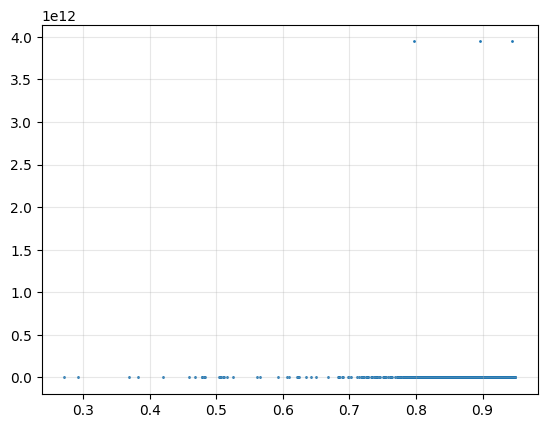

In [7]:
from predictors.linear_regression import LRPredictor

lr_predictor = LRPredictor()
lr_predictor.fit(train_data, train_targets)

lr_predictions = lr_predictor.predict(test_data)

plt.scatter(test_targets, lr_predictions, s=1)
plt.grid(alpha=0.3)
plt.show()

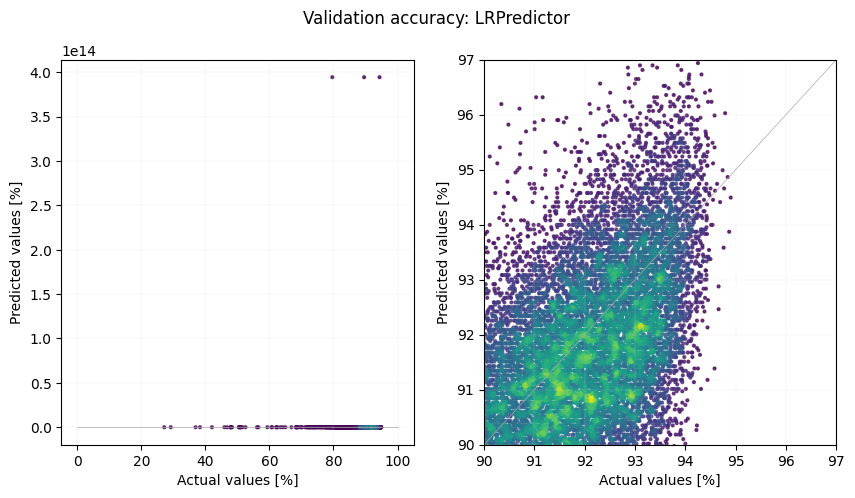

In [8]:
from utils import scatter_plot2

scatter_plot2(test_targets*100, lr_predictions*100, "Validation accuracy: LRPredictor", dense=True)

In [10]:
print(lr_predictor.evaluate(test_data, test_targets))

{'rmse': 56054894096.841255, 'mae': 812885719.2814145, 'mse': 3.1421511522080884e+21, 'pearson': -0.0018884364253225492, 'spearman': 0.6571406318072646, 'kendalltau': 0.4729186826825789, 'r2_score': -3.688411240656617e+24}


### Random Forest
- [x] Module Imports check
- [x] Save & Load 
- [x] Training & Retraining
- [x] Predicting
- [x] Plotting
- [x] Evaluation
- [x] Parameter usefulness
- [x] Hyperparameter tuning
- [x] Repr, Str

In [7]:
from predictors.random_forest import RFPredictor

rf_predictor = RFPredictor()
print(rf_predictor)

RFPredictor:
  Model Status: not fitted
  Encoding Type: adj_onehot
  Search Space Type: nasbench101
  Model Architecture: None
  Hyperparameters: default
  Mean (train): None
  Std (train): None



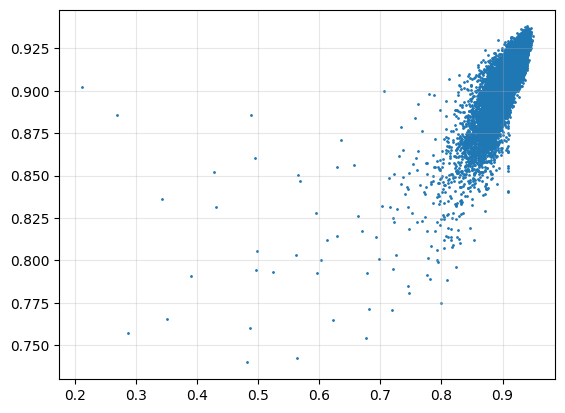

In [8]:
rf_predictor.fit(train_data, train_targets)

rf_predictions = rf_predictor.predict(test_data)

plt.scatter(test_targets, rf_predictions, s=1)
plt.grid(alpha=0.3)
plt.show()

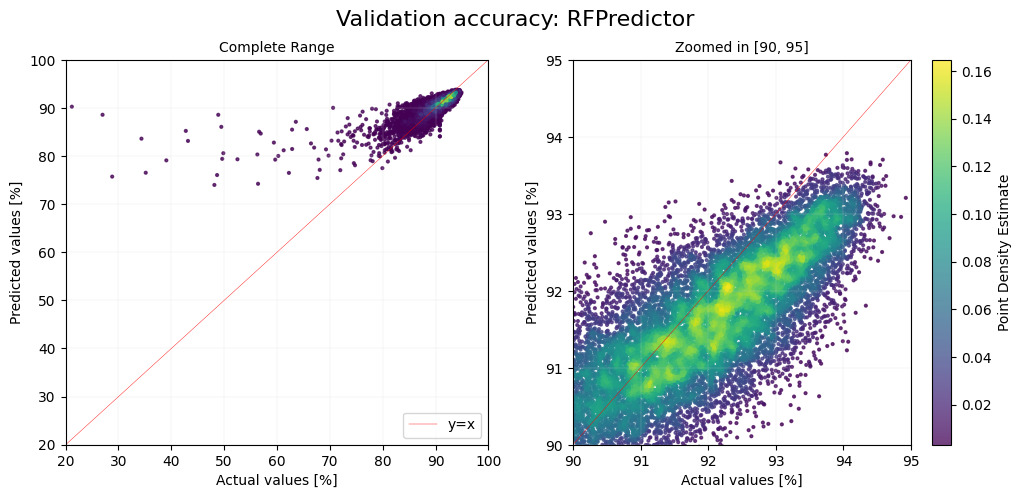

In [9]:
from utils import scatter_plot_nice 

scatter_plot_nice(test_targets*100, rf_predictions*100, "Validation accuracy: RFPredictor", dense=True)

In [13]:
print(rf_predictor.evaluate(test_data, test_targets))

{'rmse': 0.023792982635430414, 'mae': 0.014110764655211388, 'mse': 0.0005661060226898932, 'pearson': 0.6145760331408647, 'spearman': 0.6822684857178032, 'kendalltau': 0.49561523609942804, 'r2_score': 0.3354769658278577}


In [16]:
{'rmse': 0.023792982635430414, 'mae': 0.014110764655211388, 'mse': 0.0005661060226898932, 'pearson': 0.6145760331408647, 'spearman': 0.6822684857178032, 'kendalltau': 0.49561523609942804, 'r2_score': 0.3354769658278577}
{'rmse': 0.02210169668482314, 'mae': 0.012499770380779564, 'mse': 0.0004884849963479222, 'pearson': 0.6700527567851186, 'spearman': 0.7620951404752234, 'kendalltau': 0.5660931982470024, 'r2_score': 0.42659233622302095}

{'rmse': 0.02210169668482314,
 'mae': 0.012499770380779564,
 'mse': 0.0004884849963479222,
 'pearson': 0.6700527567851186,
 'spearman': 0.7620951404752234,
 'kendalltau': 0.5660931982470024,
 'r2_score': 0.42659233622302095}

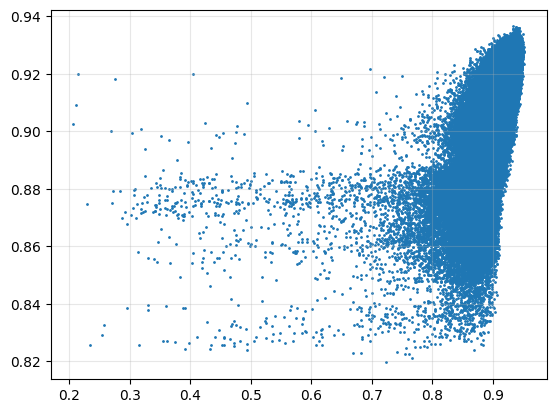

In [14]:
rf_predictor.refit(train_data_boosted, train_targets)

rf_predictions = rf_predictor.predict(test_data_boosted)

plt.scatter(test_targets, rf_predictions, s=1)
plt.grid(alpha=0.3)
plt.show()

In [15]:
print(rf_predictor.evaluate(test_data_boosted, test_targets))

{'rmse': 0.02210169668482314, 'mae': 0.012499770380779564, 'mse': 0.0004884849963479222, 'pearson': 0.6700527567851186, 'spearman': 0.7620951404752234, 'kendalltau': 0.5660931982470024, 'r2_score': 0.42659233622302095}


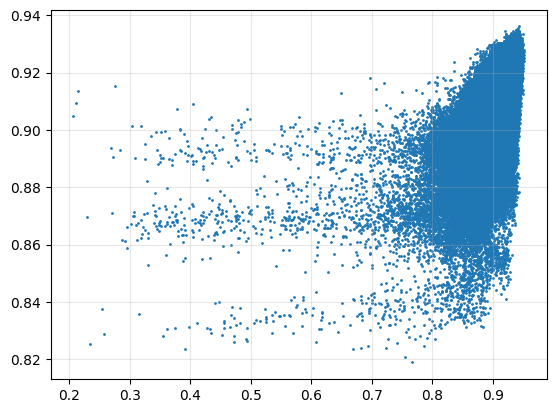

In [17]:
rf_predictor.save('models/rf_predictor3.pkl')

rf2 = RFPredictor()
rf2.load('models/rf_predictor3.pkl')

rf2_predictions = rf2.predict(test_data)

plt.scatter(test_targets, rf2_predictions, s=1)
plt.grid(alpha=0.3)
plt.show()

In [18]:
print(rf_predictor.get_hyperparams())
print(rf2.get_hyperparams())

{'n_estimators': 116, 'max_features': 0.17055852159745608, 'min_samples_leaf': 2, 'min_samples_split': 2, 'bootstrap': False}
{'n_estimators': 116, 'max_features': 0.17055852159745608, 'min_samples_leaf': 2, 'min_samples_split': 2, 'bootstrap': False}


In [22]:
import time 

start = time.time()

best_hyperparams, best_cv_score = rf_predictor.run_hpo(
    xtrain=train_data,
    ytrain=train_targets,
    start_time=start,
    metric="kendalltau",
    max_iters=5000,
    verbose=True
)

Starting cross validation
[0/5000] cv_score=0.3915, params={'n_estimators': 102, 'max_features': 0.814354694662315, 'min_samples_leaf': 18, 'min_samples_split': 11, 'bootstrap': False}
--> new best score = 0.39151002423118136, hparams = {'n_estimators': 102, 'max_features': 0.814354694662315, 'min_samples_leaf': 18, 'min_samples_split': 11, 'bootstrap': False}
patience = 0/50
[1/5000] cv_score=0.4049, params={'n_estimators': 86, 'max_features': 0.10581829183715025, 'min_samples_leaf': 10, 'min_samples_split': 15, 'bootstrap': False}
--> new best score = 0.40494695910913686, hparams = {'n_estimators': 86, 'max_features': 0.10581829183715025, 'min_samples_leaf': 10, 'min_samples_split': 15, 'bootstrap': False}
patience = 0/50
[2/5000] cv_score=0.3974, params={'n_estimators': 96, 'max_features': 0.482483622178078, 'min_samples_leaf': 19, 'min_samples_split': 5, 'bootstrap': False}
patience = 1/50
[3/5000] cv_score=0.3792, params={'n_estimators': 56, 'max_features': 0.6069745106117215, 'mi

### XGBoost
- [x] Module Imports check
- [x] Save & Load 
- [x] Training & Retraining
- [x] Predicting
- [x] Plotting
- [x] Evaluation (Kendall is too good?)
- [x] Parameter usefulness

In [10]:
from predictors.xgb import XGBPredictor

xgb_predictor = XGBPredictor()
print(xgb_predictor)

XGBPredictor:
  Model Status: not fitted
  Encoding Type: adj_one_hot
  Search Space Type: nasbench101
  Model Architecture: None
  Hyperparameters: default
  Mean (train): None
  Std (train): None



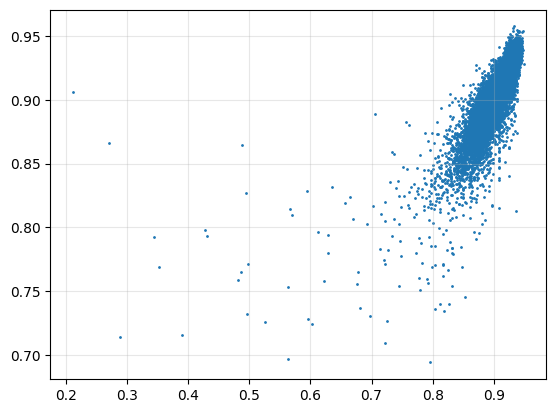

In [11]:
xgb_predictor.fit(train_data, train_targets)

xgb_predictions = xgb_predictor.predict(test_data)

plt.scatter(test_targets, xgb_predictions, s=1)
plt.grid(alpha=0.3)
plt.show()

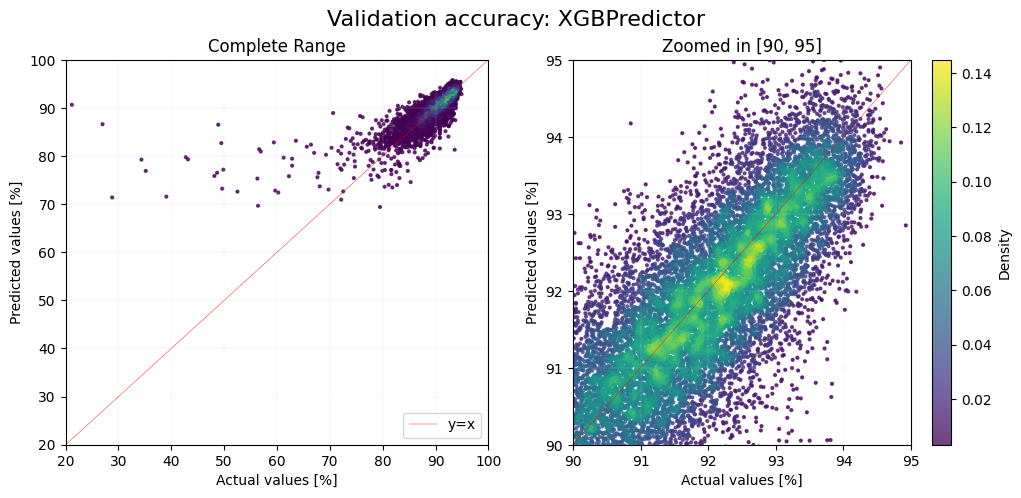

In [12]:
scatter_plot_nice(test_targets*100, xgb_predictions*100, "Validation accuracy: XGBPredictor", dense=True)

In [19]:
print(xgb_predictor.evaluate(test_data, test_targets))

{'rmse': 0.025246360358039018, 'mae': 0.01510277206391272, 'mse': 0.0006373787113279641, 'pearson': 0.5318981301301889, 'spearman': 0.635809965117359, 'kendalltau': 0.45480923302856757, 'r2_score': 0.2518135858088081}


In [ ]:
{'rmse': 0.025246360358039018, 'mae': 0.01510277206391272, 'mse': 0.0006373787113279641, 'pearson': 0.5318981301301889, 'spearman': 0.635809965117359, 'kendalltau': 0.45480923302856757, 'r2_score': 0.2518135858088081}
{'rmse': 0.022301389100501598, 'mae': 0.01257827835660534, 'mse': 0.0004973519558119715, 'pearson': 0.6482337692330711, 'spearman': 0.7666151893516495, 'kendalltau': 0.5677486062676125, 'r2_score': 0.41618386400975294}

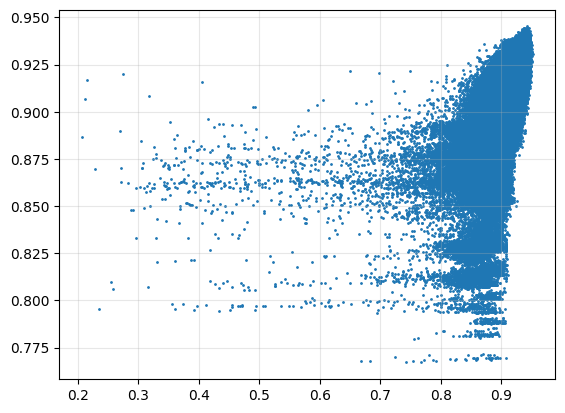

In [20]:
xgb_predictor.refit(train_data_boosted, train_targets)

xgb_predictions = xgb_predictor.predict(test_data_boosted)

plt.scatter(test_targets, xgb_predictions, s=1)
plt.grid(alpha=0.3)
plt.show()

In [21]:
print(xgb_predictor.evaluate(test_data_boosted, test_targets))

{'rmse': 0.022301389100501598, 'mae': 0.01257827835660534, 'mse': 0.0004973519558119715, 'pearson': 0.6482337692330711, 'spearman': 0.7666151893516495, 'kendalltau': 0.5677486062676125, 'r2_score': 0.41618386400975294}


In [28]:
xgb_predictor.save('models/xgb_predictor3.pkl')

xgb2 = XGBPredictor()

xgb2.load('models/xgb_predictor3.pkl')

In [29]:
print(xgb2)
print(xgb_predictor.get_hyperparams())
print(xgb2.get_hyperparams())

XGBPredictor:
  Model Status: fitted
  Encoding Type: adj_one_hot
  Search Space Type: nasbench101
  Model Architecture: XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
  Hyperparameters: objective=reg:squarederror, eval_metric=rmse, booster=gbtree, max_depth=6, min_child_weight=1, colsample_bytree=1, learning_ra

In [30]:
import time 

start = time.time()

best_hyperparams, best_cv_score = xgb_predictor.run_hpo(
    xtrain=train_data,
    ytrain=train_targets,
    start_time=start,
    metric="kendalltau",
    max_iters=5000,
    k=5,
    verbose=True
)

Starting cross validation
[0/5000] cv_score=0.4454, params={'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'max_depth': 4, 'min_child_weight': 6, 'colsample_bytree': 0.9369062694919504, 'learning_rate': 0.04608628810141053, 'colsample_bylevel': 0.5715543486338273}
--> new best score = 0.44538101350706283, hparams = {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'max_depth': 4, 'min_child_weight': 6, 'colsample_bytree': 0.9369062694919504, 'learning_rate': 0.04608628810141053, 'colsample_bylevel': 0.5715543486338273}
patience = 0/50
[1/5000] cv_score=0.4454, params={'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'max_depth': 6, 'min_child_weight': 5, 'colsample_bytree': 0.9027915369863908, 'learning_rate': 0.0011693544224903479, 'colsample_bylevel': 0.04574673635023385}
patience = 1/50
[2/5000] cv_score=0.4454, params={'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'm

### GCN
- [] Module Imports check
- [] Save & Load 
- [] Training & Retraining
- [] Predicting
- [] Plotting
- [] Evaluation (Kendall is too good?)
- [] Parameter usefulness

In [32]:
gcn_train_data = np.array(list([a for a in dataset]))
gcn_test_data = np.array(list([a for a in dataset_test]))


In [33]:
from predictors.gcn import GCNPredictor

gcn_predictor = GCNPredictor()
print(gcn_predictor)

GCNPredictor:
  Model Status: not fitted
  Encoding Type: gcn_graph
  Search Space Type: nasbench101
  Model Architecture: None
  Hyperparameters: default
  Mean (train): None
  Std (train): None



[05/10 00:59:02] INFO (root) Epoch 1/300, Loss: 1.0006, MSE: 10005.9629
[05/10 00:59:03] INFO (root) Epoch 2/300, Loss: 1.0035, MSE: 10034.7430
[05/10 00:59:03] INFO (root) Epoch 3/300, Loss: 1.0030, MSE: 10030.4873
[05/10 00:59:03] INFO (root) Epoch 4/300, Loss: 0.9929, MSE: 9928.9110
[05/10 00:59:03] INFO (root) Epoch 5/300, Loss: 0.9924, MSE: 9923.5635
[05/10 00:59:03] INFO (root) Epoch 6/300, Loss: 0.9923, MSE: 9922.7239
[05/10 00:59:03] INFO (root) Epoch 7/300, Loss: 0.9913, MSE: 9913.4561
[05/10 00:59:03] INFO (root) Epoch 8/300, Loss: 0.9907, MSE: 9906.7830
[05/10 00:59:04] INFO (root) Epoch 9/300, Loss: 0.9890, MSE: 9890.4050
[05/10 00:59:04] INFO (root) Epoch 10/300, Loss: 0.9860, MSE: 9860.4332
[05/10 00:59:04] INFO (root) Epoch 11/300, Loss: 0.9827, MSE: 9826.8053
[05/10 00:59:04] INFO (root) Epoch 12/300, Loss: 0.9775, MSE: 9775.0271
[05/10 00:59:04] INFO (root) Epoch 13/300, Loss: 0.9720, MSE: 9720.3623
[05/10 00:59:04] INFO (root) Epoch 14/300, Loss: 0.9644, MSE: 9643.510

c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\_utils\collate.py:176: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  return torch.as_tensor(batch)


[05/10 00:59:45] INFO (root) Batch 5, Loss: 1.3521, MSE: 13520.8682
[05/10 00:59:45] INFO (root) Batch 6, Loss: 1.3405, MSE: 13404.9738
[05/10 00:59:45] INFO (root) Batch 7, Loss: 1.3306, MSE: 13306.0619
[05/10 00:59:45] INFO (root) Batch 8, Loss: 1.3172, MSE: 13172.0700
[05/10 00:59:45] INFO (root) Batch 9, Loss: 1.3150, MSE: 13150.1714
[05/10 00:59:45] INFO (root) Batch 10, Loss: 1.3227, MSE: 13227.4903
[05/10 00:59:45] INFO (root) Batch 11, Loss: 1.3251, MSE: 13251.4517
[05/10 00:59:45] INFO (root) Batch 12, Loss: 1.3174, MSE: 13173.6359
[05/10 00:59:45] INFO (root) Batch 13, Loss: 1.3082, MSE: 13082.0348
[05/10 00:59:45] INFO (root) Batch 14, Loss: 1.3174, MSE: 13173.9450
[05/10 00:59:45] INFO (root) Batch 15, Loss: 1.3119, MSE: 13119.2375
[05/10 00:59:45] INFO (root) Batch 16, Loss: 1.3129, MSE: 13128.7666
[05/10 00:59:45] INFO (root) Batch 17, Loss: 1.3078, MSE: 13078.0229
[05/10 00:59:45] INFO (root) Batch 18, Loss: 1.3105, MSE: 13104.8772
[05/10 00:59:45] INFO (root) Batch 19, 

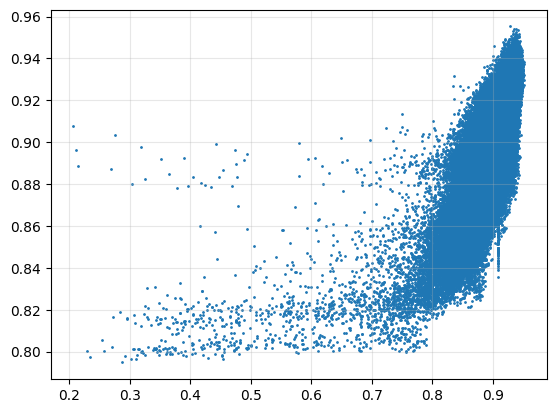

In [34]:
gcn_predictor.fit(gcn_train_data, train_targets)

gcn_predictions = gcn_predictor.predict(gcn_test_data)

plt.scatter(test_targets, gcn_predictions, s=1)
plt.grid(alpha=0.3)
plt.show()

In [35]:
print(gcn_predictor)

GCNPredictor:
  Model Status: fitted
  Encoding Type: gcn_graph
  Search Space Type: nasbench101
  Model Architecture: NeuralPredictorModel(
  (gcn): ModuleList(
    (0): DirectedGraphConvolution (5 -> 144)
    (1): DirectedGraphConvolution (144 -> 144)
    (2): DirectedGraphConvolution (144 -> 144)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=144, out_features=128, bias=False)
  (fc2): Linear(in_features=128, out_features=1, bias=False)
)
  Hyperparameters: gcn_hidden=144, batch_size=10, lr=0.0001, wd=0.001, epochs=300, eval_batch_size=1000
  Mean (train): 0.9085
  Std (train): 0.0265



In [36]:
gcn_predictor.save('models/gcn_172_random2.pkl')

gcn_new2 = GCNPredictor()
gcn_new2.load('models/gcn_172_random2.pkl')

In [37]:
print(gcn_new2)

GCNPredictor:
  Model Status: fitted
  Encoding Type: gcn_graph
  Search Space Type: nasbench101
  Model Architecture: NeuralPredictorModel(
  (gcn): ModuleList(
    (0): DirectedGraphConvolution (5 -> 144)
    (1): DirectedGraphConvolution (144 -> 144)
    (2): DirectedGraphConvolution (144 -> 144)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=144, out_features=128, bias=False)
  (fc2): Linear(in_features=128, out_features=1, bias=False)
)
  Hyperparameters: gcn_hidden=144, batch_size=10, lr=0.0001, wd=0.001, epochs=300, eval_batch_size=1000
  Mean (train): 0.9085
  Std (train): 0.0265



### MLP
- [] Module Imports check
- [] Save & Load 
- [] Training & Retraining
- [] Predicting
- [] Plotting
- [] Evaluation (Kendall is too good?)
- [] Parameter usefulness

In [22]:
from predictors.mlp import MLPPredictor

mlp_predictor = MLPPredictor()
print(mlp_predictor)

MLPPredictor:
  Model Status: not fitted
  Encoding Type: adj_onehot
  Search Space Type: nasbench101
  Model Architecture: None
  Hyperparameters: default
  Mean (train): None
  Std (train): None



[05/12 14:16:43] INFO (root) Epoch 1, Loss: 2.0854
[05/12 14:16:43] INFO (root) Epoch 2, Loss: 2.0610
[05/12 14:16:43] INFO (root) Epoch 3, Loss: 2.0371
[05/12 14:16:43] INFO (root) Epoch 4, Loss: 2.0129
[05/12 14:16:43] INFO (root) Epoch 5, Loss: 1.9898
[05/12 14:16:43] INFO (root) Epoch 6, Loss: 1.9648
[05/12 14:16:43] INFO (root) Epoch 7, Loss: 1.9412
[05/12 14:16:43] INFO (root) Epoch 8, Loss: 1.9201
[05/12 14:16:43] INFO (root) Epoch 9, Loss: 1.8970
[05/12 14:16:43] INFO (root) Epoch 10, Loss: 1.8741
[05/12 14:16:43] INFO (root) Epoch 11, Loss: 1.8488
[05/12 14:16:44] INFO (root) Epoch 12, Loss: 1.8185
[05/12 14:16:44] INFO (root) Epoch 13, Loss: 1.7810
[05/12 14:16:44] INFO (root) Epoch 14, Loss: 1.7281
[05/12 14:16:44] INFO (root) Epoch 15, Loss: 1.6315
[05/12 14:16:44] INFO (root) Epoch 16, Loss: 1.4610
[05/12 14:16:44] INFO (root) Epoch 17, Loss: 1.3369
[05/12 14:16:44] INFO (root) Epoch 18, Loss: 1.2327
[05/12 14:16:44] INFO (root) Epoch 19, Loss: 1.1617
[05/12 14:16:44] INFO

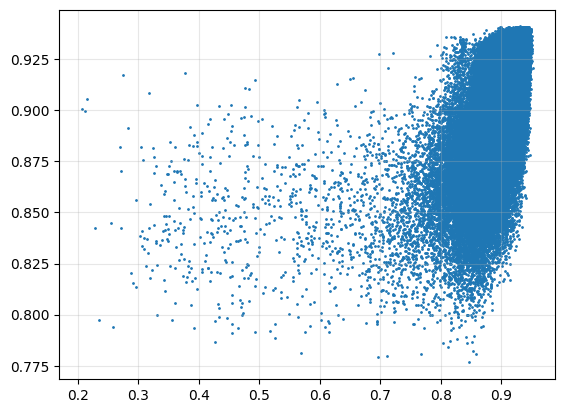

In [23]:
mlp_predictor.fit(train_data, train_targets)

mlp_predictions = mlp_predictor.predict(test_data)

plt.scatter(test_targets, mlp_predictions, s=1)
plt.grid(alpha=0.3)
plt.show()

In [24]:
print(mlp_predictor.evaluate(test_data, test_targets))

{'rmse': 0.02331335998024123, 'mae': 0.014246860233605857, 'mse': 0.0005435127535683133, 'pearson': 0.623232462350765, 'spearman': 0.6210395573245999, 'kendalltau': 0.4437350439105564, 'r2_score': 0.3619980540105996}


In [ ]:
{'rmse': 0.02331335998024123, 'mae': 0.014246860233605857, 'mse': 0.0005435127535683133, 'pearson': 0.623232462350765, 'spearman': 0.6210395573245999, 'kendalltau': 0.4437350439105564, 'r2_score': 0.3619980540105996}
{'rmse': 0.02158106254298819, 'mae': 0.012547753686839719, 'mse': 0.0004657422604843679, 'pearson': 0.6857557557667239, 'spearman': 0.7785349794525072, 'kendalltau': 0.5794880998861416, 'r2_score': 0.4532888758033876}

[05/12 14:19:01] INFO (root) Epoch 1, Loss: 2.0902
[05/12 14:19:01] INFO (root) Epoch 2, Loss: 2.0660
[05/12 14:19:01] INFO (root) Epoch 3, Loss: 2.0432
[05/12 14:19:01] INFO (root) Epoch 4, Loss: 2.0203
[05/12 14:19:01] INFO (root) Epoch 5, Loss: 1.9973
[05/12 14:19:01] INFO (root) Epoch 6, Loss: 1.9746
[05/12 14:19:01] INFO (root) Epoch 7, Loss: 1.9520
[05/12 14:19:01] INFO (root) Epoch 8, Loss: 1.9306
[05/12 14:19:01] INFO (root) Epoch 9, Loss: 1.9084
[05/12 14:19:01] INFO (root) Epoch 10, Loss: 1.8863
[05/12 14:19:01] INFO (root) Epoch 11, Loss: 1.8620
[05/12 14:19:01] INFO (root) Epoch 12, Loss: 1.8256
[05/12 14:19:01] INFO (root) Epoch 13, Loss: 1.7512
[05/12 14:19:01] INFO (root) Epoch 14, Loss: 1.6481
[05/12 14:19:02] INFO (root) Epoch 15, Loss: 1.4694
[05/12 14:19:02] INFO (root) Epoch 16, Loss: 1.3560
[05/12 14:19:02] INFO (root) Epoch 17, Loss: 1.3555
[05/12 14:19:02] INFO (root) Epoch 18, Loss: 1.2193
[05/12 14:19:02] INFO (root) Epoch 19, Loss: 1.2698
[05/12 14:19:02] INFO

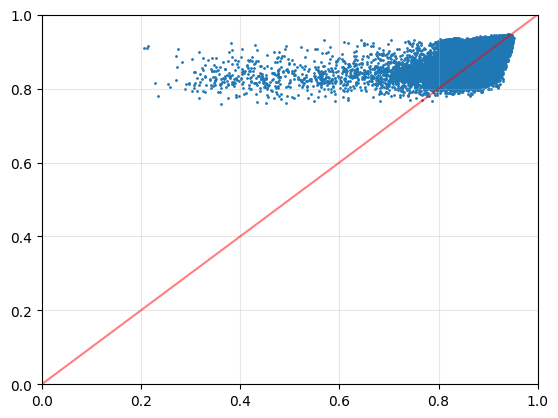

In [27]:
mlp_predictor.refit(train_data_boosted, train_targets)

mlp_predictions = mlp_predictor.predict(test_data_boosted)

plt.scatter(test_targets, mlp_predictions, s=1)
plt.plot([0, 1], [0, 1], color='red', alpha=0.5)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.show()

In [26]:
print(mlp_predictor.evaluate(test_data_boosted, test_targets))

{'rmse': 0.02158106254298819, 'mae': 0.012547753686839719, 'mse': 0.0004657422604843679, 'pearson': 0.6857557557667239, 'spearman': 0.7785349794525072, 'kendalltau': 0.5794880998861416, 'r2_score': 0.4532888758033876}


In [8]:
mlp_predictor.save('models/mlp_predictor_172.pkl')

mlp2 = MLPPredictor()
mlp2.load('models/mlp_predictor_172.pkl')

In [9]:
print(mlp2)

MLPPredictor:
  Model Status: fitted
  Encoding Type: adj_onehot
  Search Space Type: nasbench101
  Model Architecture: FeedforwardNet(
  (layers): ModuleList(
    (0): Linear(in_features=84, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Linear(in_features=20, out_features=20, bias=True)
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): Linear(in_features=20, out_features=20, bias=True)
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): Linear(in_features=20, out_features=20, bias=Tr

In [12]:
mlp2.refit(train_data, train_targets)

[05/10 01:17:39] INFO (root) Epoch 1, Loss: 2.1215
[05/10 01:17:39] INFO (root) Epoch 2, Loss: 2.0969
[05/10 01:17:39] INFO (root) Epoch 3, Loss: 2.0723
[05/10 01:17:39] INFO (root) Epoch 4, Loss: 2.0496
[05/10 01:17:39] INFO (root) Epoch 5, Loss: 2.0267
[05/10 01:17:39] INFO (root) Epoch 6, Loss: 2.0039
[05/10 01:17:39] INFO (root) Epoch 7, Loss: 1.9821
[05/10 01:17:39] INFO (root) Epoch 8, Loss: 1.9623
[05/10 01:17:39] INFO (root) Epoch 9, Loss: 1.9429
[05/10 01:17:39] INFO (root) Epoch 10, Loss: 1.9245
[05/10 01:17:39] INFO (root) Epoch 11, Loss: 1.9059
[05/10 01:17:39] INFO (root) Epoch 12, Loss: 1.8869
[05/10 01:17:39] INFO (root) Epoch 13, Loss: 1.8668
[05/10 01:17:39] INFO (root) Epoch 14, Loss: 1.8437
[05/10 01:17:39] INFO (root) Epoch 15, Loss: 1.8163
[05/10 01:17:39] INFO (root) Epoch 16, Loss: 1.7821
[05/10 01:17:39] INFO (root) Epoch 17, Loss: 1.7314
[05/10 01:17:39] INFO (root) Epoch 18, Loss: 1.6540
[05/10 01:17:39] INFO (root) Epoch 19, Loss: 1.5852
[05/10 01:17:39] INFO

In [4]:
dataset = NASBench101Dataset('data/nasbench.hdf5', "2000") 
dataset_test = NASBench101Dataset('data/nasbench.hdf5', "all")
dataset_size = len(dataset)

In [9]:
gcn_train_data = np.array(list([a for a in dataset]))
gcn_test_data = np.array(list([a for a in dataset_test]))

train_targets = get_targets2(dataset)
test_targets = get_targets2(dataset_test)

[05/10 02:41:38] INFO (root) Epoch 1/300, Loss: 1.0081, MSE: 10081.4535
[05/10 02:41:38] INFO (root) Epoch 2/300, Loss: 1.0071, MSE: 10070.9708
[05/10 02:41:38] INFO (root) Epoch 3/300, Loss: 1.0065, MSE: 10065.2659
[05/10 02:41:38] INFO (root) Epoch 4/300, Loss: 1.0046, MSE: 10045.8795
[05/10 02:41:38] INFO (root) Epoch 5/300, Loss: 1.0033, MSE: 10032.6997
[05/10 02:41:39] INFO (root) Epoch 6/300, Loss: 1.0023, MSE: 10023.2359
[05/10 02:41:39] INFO (root) Epoch 7/300, Loss: 1.0002, MSE: 10001.8853
[05/10 02:41:39] INFO (root) Epoch 8/300, Loss: 0.9980, MSE: 9980.4038
[05/10 02:41:39] INFO (root) Epoch 9/300, Loss: 0.9921, MSE: 9921.1878
[05/10 02:41:39] INFO (root) Epoch 10/300, Loss: 0.9899, MSE: 9898.8298
[05/10 02:41:39] INFO (root) Epoch 11/300, Loss: 0.9868, MSE: 9867.5497
[05/10 02:41:39] INFO (root) Epoch 12/300, Loss: 0.9821, MSE: 9821.2573
[05/10 02:41:40] INFO (root) Epoch 13/300, Loss: 0.9751, MSE: 9751.2178
[05/10 02:41:40] INFO (root) Epoch 14/300, Loss: 0.9686, MSE: 9685

c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\_utils\collate.py:176: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  return torch.as_tensor(batch)


[05/10 02:42:20] INFO (root) Batch 6, Loss: 1.3052, MSE: 13052.1011
[05/10 02:42:20] INFO (root) Batch 7, Loss: 1.2948, MSE: 12947.5412
[05/10 02:42:20] INFO (root) Batch 8, Loss: 1.2813, MSE: 12812.9721
[05/10 02:42:20] INFO (root) Batch 9, Loss: 1.2781, MSE: 12781.4139
[05/10 02:42:20] INFO (root) Batch 10, Loss: 1.2861, MSE: 12861.0830
[05/10 02:42:20] INFO (root) Batch 11, Loss: 1.2892, MSE: 12891.7034
[05/10 02:42:20] INFO (root) Batch 12, Loss: 1.2822, MSE: 12821.5848
[05/10 02:42:20] INFO (root) Batch 13, Loss: 1.2745, MSE: 12744.9177
[05/10 02:42:20] INFO (root) Batch 14, Loss: 1.2830, MSE: 12830.2592
[05/10 02:42:20] INFO (root) Batch 15, Loss: 1.2778, MSE: 12778.2017
[05/10 02:42:20] INFO (root) Batch 16, Loss: 1.2787, MSE: 12787.0203
[05/10 02:42:20] INFO (root) Batch 17, Loss: 1.2736, MSE: 12735.6505
[05/10 02:42:20] INFO (root) Batch 18, Loss: 1.2763, MSE: 12763.4222
[05/10 02:42:20] INFO (root) Batch 19, Loss: 1.2753, MSE: 12753.1660
[05/10 02:42:20] INFO (root) Batch 20,

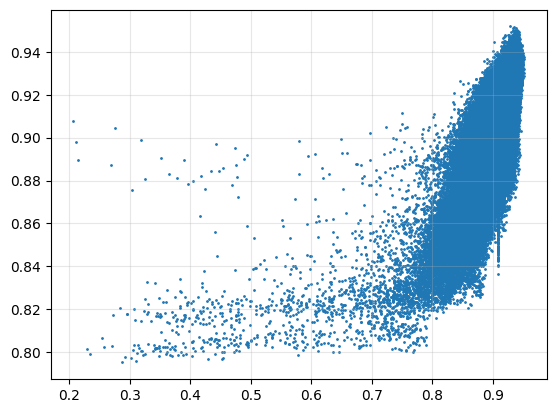

In [10]:
from predictors.gcn import GCNPredictor

gcn = GCNPredictor()

gcn.fit(gcn_train_data, train_targets)

gcn_predictions = gcn.predict(gcn_test_data)

plt.scatter(test_targets, gcn_predictions, s=1)
plt.grid(alpha=0.3)
plt.show()

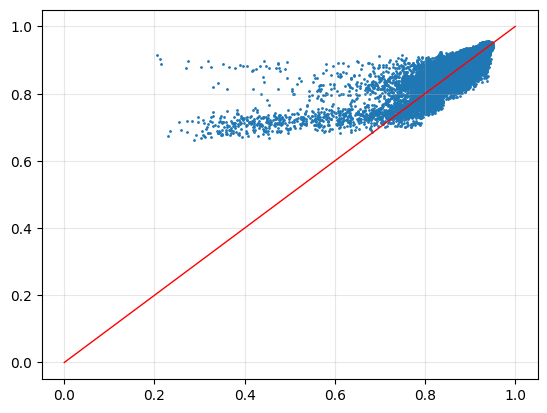

In [9]:
plt.scatter(test_targets, gcn_predictions, s=1)
plt.plot([0, 1], [0, 1], color='red', linewidth=1)
plt.grid(alpha=0.3)
plt.show()

In [10]:
print(gcn.evaluate(gcn_test_data, test_targets))

[05/10 02:20:53] INFO (root) Batch 1, Loss: 1.4963, MSE: 14963.2646
[05/10 02:20:53] INFO (root) Batch 2, Loss: 1.5024, MSE: 15023.9477
[05/10 02:20:53] INFO (root) Batch 3, Loss: 1.5608, MSE: 15608.0929
[05/10 02:20:53] INFO (root) Batch 4, Loss: 1.5655, MSE: 15654.7170
[05/10 02:20:53] INFO (root) Batch 5, Loss: 1.6241, MSE: 16240.7295
[05/10 02:20:53] INFO (root) Batch 6, Loss: 1.6058, MSE: 16058.2848
[05/10 02:20:53] INFO (root) Batch 7, Loss: 1.5894, MSE: 15894.2088
[05/10 02:20:53] INFO (root) Batch 8, Loss: 1.5553, MSE: 15552.5111
[05/10 02:20:53] INFO (root) Batch 9, Loss: 1.5482, MSE: 15481.5956
[05/10 02:20:53] INFO (root) Batch 10, Loss: 1.5450, MSE: 15449.9758
[05/10 02:20:53] INFO (root) Batch 11, Loss: 1.5574, MSE: 15573.5677
[05/10 02:20:53] INFO (root) Batch 12, Loss: 1.5493, MSE: 15493.0761
[05/10 02:20:53] INFO (root) Batch 13, Loss: 1.5410, MSE: 15410.1432
[05/10 02:20:53] INFO (root) Batch 14, Loss: 1.5543, MSE: 15542.5703
[05/10 02:20:53] INFO (root) Batch 15, Loss

In [4]:
dataset = NASBench101Dataset('data/nasbench101.hdf5', "172") 
dataset_test = NASBench101Dataset('data/nasbench101.hdf5', "all")
dataset_size = len(dataset)

In [5]:
print(dataset[0])

{'num_vertices': 7, 'adjacency': (array([[0, 1, 0, 1, 0, 0, 1],
       [0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0]], dtype=int8),), 'operations': array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]], dtype=float32), 'mask': array([1., 1., 1., 1., 1., 1., 1.], dtype=float32), 'val_acc': 0.92477965, 'test_acc': 0.91316104, 'depth': 0}
